In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip freeze | grep sklearn

sklearn==0.0
sklearn-pandas==1.8.0


We use a product review dataset

In [ ]:
!cp drive/MyDrive/Research/Barmajan/*.txt .

## Imports

In [ ]:
import tensorflow as tf
import numpy as np
import os
import time
import glob
from tensorflow.keras.layers import GRU, Embedding, Dense, Input, Dropout, Bidirectional, BatchNormalization, Flatten, Reshape
from tensorflow.keras.models import Sequential
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
with open('labels.txt', 'r') as f:
  label2name = f.readlines()
  label2name = [name.replace('\n', '') for name in label2name]

## Read the Dataset

In [ ]:
import random
random.seed(400)

preprocess a review by removing special characters and long spaces

In [ ]:
vocab = list('إةابتثجحخدذرزسشصضطظعغفقكلمنهويىأءئؤ#آ ')
vocab += list('ًٌٍَُِّ') +['ْ']+['ٓ']

In [ ]:
# Read, then decode for py2 compat.
def extract_data(path, thresh = 128, on_shatrs = False, set_max = -1):
  global vocab

  char_mapper = {
      'ک':'ك',
      'ﺑ':'ب',
      'ھ':'ه',
      'ی':'ى'
  }
  text = ""
  
  X = []
  y = []
    
  t = open(path, 'r').read()
  
  # remove some exteranous chars 
  # execluded = '!()*-ـ.:=o[]«»;؛,،~?؟\u200f\ufeffـ'
  out = ""
  
  baits = t.split('\n')
  ex_chars = []

  for i, line in enumerate(baits):
    if i > set_max and set_max != -1:
      break
    if len(line) <= 1:
      continue
    label, bait = line.split(' ', 1)
    cleaned_bait = ""
    
    for char in bait:
      if char in vocab:
        cleaned_bait += char
      elif char in char_mapper:
        cleaned_bait += char_mapper[char]
      else:
        ex_chars.append(char)
    label = int(label)
    cleaned_bait  = cleaned_bait.strip()
    # if len(cleaned_bait) == 1:
    #   print(cleaned_bait, label,line)
    if len(cleaned_bait) > thresh:
      print(cleaned_bait)
      continue
    if on_shatrs:
      shatrs = cleaned_bait.split('#')
      for shatr in shatrs:
        X.append(shatr.strip())
        y.append(label)
    else:
        X.append(cleaned_bait.strip())
        y.append(label)
  
  #shuffle the data
  print(set(ex_chars))
  print(len(X)) 
  X, y = shuffle(X, y, random_state = 41)
  return X, y

In [ ]:
# X, y = extract_data("train.txt",)
X_text, y_text = extract_data("train.txt",)
X_text_test, y_text_test = extract_data("test.txt")

قَوْلُهُ قِنًّا كُلُّهُ خَرَجَ الْمُبَعَّضُ فَهَلْ الْمُرَادُ أَنَّ # لَهُ جَمِيعَ الْمَهْرِ أَوْ أَنَّ لَهُ بِقِسْطِهِ رَاجِعْهُ
أَمَّا إذَا أَكَلَ مِنْهُ وَلَمْ يَقْتُلْهُ أَوْ قَتَلَهُ # ثُمَّ انْصَرَفَ وَعَادَ إلَيْهِ فَأَكَلَ مِنْهُ فَإِنَّهُ لَا يَضُرُّ
وَمُطْلَقُ مَسِّ ذَكَرِهِ الْمُتَّصِلِ وَلَوْ خُنْثَى مُشْكِلًا بِبَطْنٍ # أَوْ جَنْبٍ لِكَفٍّ أَوْ إصْبَعٍ وَإِنْ زَائِدًا حَسَّ
وَقَالَ ابْنُ سَعْدٍ رَوَى عَنْ أُبَيِّ بْنِ كَعْبٍ # وَعُثْمَانَ وَعَلِيٍّ وَكَانَ ثِقَةً لَهُ فَضْلٌ وَوَرَعٌ وَعَقْلٌ وَأَدَبٌ
الْمُصَنِّفِ لَوْ قَالَ لَهُ عَلَيَّ أَلْفٌ مِنْ ثَمَنِ مَبِيعٍ # لَمْ أَقْبِضْهُ وَقَالَ الْمُقَرُّ لَهُ بَلْ دَيْنٌ فِي ذِمَّتِك
هذي حياتي وهذا الشوقُ يُجْبِرُني  على التّغُزّلِ في آلاءِ فاتنتي # ما كلّ حُسْن بهذا الكون يَذبَحُني أوْ كُلّ رامِيَةٍ بالعين راميتي
وَإِنْ يَقُلْ وَاَللَّهِ لَا أُكَلِّمُ يَزِيدَ أَوْ عَلَيْهِ # لَا أُسَلِّمُ فَإِنْ عَلَى قَوْمٍ يُسَلِّمْ وَلَوْ مِنْ الصَّلَاةِ
إلَخْ أَيْ وَيَجُوزُ لَهُ الدَّفْعُ بِلَا بَيِّنَةٍ لَكِنْ # يُشْتَرَطُ فِي دَفْعِ الْ

In [ ]:
from collections import defaultdict

def remove_dups(X, y, lbl =14):
  meter_baits = []
  other_baits = []
  other_labels = []

  print('remove dups for ', label2name[lbl])
  assert len(X) == len(y)
  for i, bait in enumerate(X):
    label = y[i]
    if label == lbl:
      meter_baits.append(bait)
    else:
      other_baits.append(bait)
      other_labels.append(label)
  unique_baits = list(set(meter_baits))

  print('before ', len(meter_baits))
  print('after  ', len(unique_baits))
  return other_baits+unique_baits, other_labels+ [lbl] * len(unique_baits)

In [ ]:
for lbl in range(len(label2name)):
  X_text, y_text = remove_dups(X_text, y_text,  lbl =lbl,)

remove dups for  saree
before  49670
after   49487
remove dups for  kamel
before  311923
after   308754
remove dups for  mutakareb
before  55838
after   55166
remove dups for  mutadarak
before  10624
after   10578
remove dups for  munsareh
before  23648
after   23324
remove dups for  madeed
before  6155
after   6154
remove dups for  mujtath
before  14942
after   14863
remove dups for  ramal
before  66938
after   66529
remove dups for  baseet
before  203503
after   201368
remove dups for  khafeef
before  133738
after   131744
remove dups for  taweel
before  341879
after   336923
remove dups for  wafer
before  114834
after   113315
remove dups for  hazaj
before  6593
after   6531
remove dups for  rajaz
before  99578
after   98056
remove dups for  mudhare
before  111
after   111
remove dups for  muqtadheb
before  644
after   644
remove dups for  prose
before  25958
after   25624


In [ ]:
from collections import defaultdict

def augment_meter(X, y, lbl =14, aug_size = 50_000, truncate = False):
  meter_baits = []
  other_baits = []
  other_labels = []

  print('augmenting ', label2name[lbl])
  assert len(X) == len(y)

  for i, bait in enumerate(X):
    label = y[i]
    if label == lbl:
      meter_baits.append(bait)
    else:
      other_baits.append(bait)
      other_labels.append(label)

  meter_baits = shuffle(meter_baits, random_state = 41)
  aug_meter_baits = meter_baits.copy()


  cached_i_j = defaultdict(list)
  dups = []
  for i in range(0, len(meter_baits)):
    for j in range(i+1, len(meter_baits)):

      first_shatr = meter_baits[i].split('#')[1].strip()
      second_shatr = meter_baits[j].split('#')[0].strip()
      aug_bait = (' # ').join([first_shatr, second_shatr])
      
      if aug_bait in aug_meter_baits:
        continue
      aug_meter_baits.append(aug_bait)

      if len(aug_meter_baits) > aug_size:
        break
    if len(aug_meter_baits) > aug_size:
        break
    
  meter_labels = [lbl]*len(aug_meter_baits)
  if truncate:
    aug_meter_baits = aug_meter_baits[:aug_size]
    meter_labels = meter_labels[:aug_size]
    
  return other_baits + aug_meter_baits, other_labels + meter_labels

In [ ]:
X_aug, y_aug = X_text, y_text

for lbl in range(len(label2name)):
  X_aug, y_aug = augment_meter(X_aug, y_aug,  lbl =lbl, truncate = True)

augmenting  saree
augmenting  kamel
augmenting  mutakareb
augmenting  mutadarak
augmenting  munsareh
augmenting  madeed
augmenting  mujtath
augmenting  ramal
augmenting  baseet
augmenting  khafeef
augmenting  taweel
augmenting  wafer
augmenting  hazaj
augmenting  rajaz
augmenting  mudhare
augmenting  muqtadheb
augmenting  prose


In [ ]:
X_aug[-1], y_aug[-1]

('جاءَت بِناءً عَلَى نَصِيحَةٍ رُوسِيَّةٍ # أَنْ يُكَفَّنَ فِي ثِيَابِ جُمُعَتِهِ',
 16)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


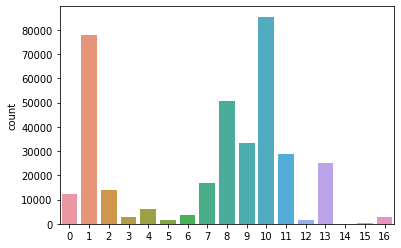

In [ ]:
import seaborn as sns
sns.countplot(y_text_test,)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


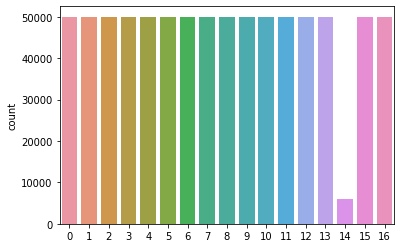

In [ ]:
import seaborn as sns
sns.countplot(y_aug, )

In [ ]:
char2idx = {u:i+1 for i, u in enumerate(vocab)}

In [ ]:
import random 

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, labels, batch_size=256, shuffle=True, augment = True):
        'Initialization'
        self.batch_size = batch_size
        self.labels = labels
        self.data = data
        self.shuffle = shuffle
        self.tashkeel = list('ًٌٍَُِّ') +['ْ']+['ٓ']
        self.augment = augment
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indices = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(indices)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.data))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def _random_strip_tashkeel(self, text):
      out_text = ""
      for char in text:
        if char in self.tashkeel:
          if random.random() > 0.5:
            out_text += char
        else:
          out_text += char
      return out_text

    def _augment(self, text):
        if random.random() > 0.5:
          text = self._random_strip_tashkeel(text)

        if random.random() > 0.5:
          text = (' # ').join(text.split(' # ')[::-1])
        return text 

    def _preprocess_item(self, text):
        if self.augment:
          text = self._augment(text)

        x = [[char2idx[char] for char in text]]
        x = pad_sequences(x, padding='post', value=0, maxlen = 128)
        return x
      
    def __data_generation(self, indices):
        'Generates data containing batch_size samples' 

        # Initialization
        X = np.empty((self.batch_size, 128))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, index in enumerate(indices):
            X[i,] = self._preprocess_item(self.data[index])
            y[i] = self.labels[index]

        return X, y

In [ ]:
X_train, X_valid , y_train, y_valid = train_test_split(X_aug, y_aug, test_size = 0.15, random_state = 41)

In [ ]:
train_generator = DataGenerator(X_train, y_train)
valid_generator = DataGenerator(X_valid, y_valid, augment = False, shuffle=False)

## Create the model

In [ ]:
def create_model():
  model = Sequential()
  model.add(Input((128,)))
  model.add(Embedding(len(char2idx)+1, 256))
  model.add(Bidirectional(GRU(units = 256, return_sequences=True)))
  model.add(Bidirectional(GRU(units = 256, return_sequences=True)))
  model.add(Bidirectional(GRU(units = 256, return_sequences=True)))
  model.add(Bidirectional(GRU(units = 256, return_sequences=True)))
  model.add(Bidirectional(GRU(units = 256)))
  model.add(Dense(128, activation = 'relu'))
  model.add(Dropout(0.3))
  model.add(Dense(len(label2name), activation = 'softmax'))
  model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
  return model

def create_model_v1():
  model = Sequential()
  model.add(Input((128,)))
  model.add(Embedding(len(char2idx)+1, 32))
  model.add(Bidirectional(GRU(units = 64, return_sequences=True)))
  model.add(Bidirectional(GRU(units = 64, return_sequences=True)))
  model.add(Bidirectional(GRU(units = 64, return_sequences=True)))
  model.add(Bidirectional(GRU(units = 64)))
  model.add(Dense(len(label2name), activation = 'softmax'))
  model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
  return model

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        # self.ffn = keras.Sequential(
        #     [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        # )
        self.ffn = keras.Sequential(
            [layers.Bidirectional(GRU(units = ff_dim, return_sequences=True)),
             layers.Bidirectional(GRU(units = ff_dim, return_sequences=True)),
             layers.Bidirectional(GRU(units = ff_dim, return_sequences=True)),
             layers.Dense(embed_dim)]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        # print(out1.shape)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        # return x + positions
        return x

def create_transformer_model():
  embed_dim = 64  # Embedding size for each token
  num_heads = 3  # Number of attention heads
  ff_dim = 64  # Hidden layer size in feed forward network inside transformer
  maxlen = 128 
  vocab_size = len(char2idx)+1
  inputs = layers.Input(shape=(maxlen,))
  embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
  x = embedding_layer(inputs)
  transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
  x = transformer_block(x)
  x = layers.Flatten()(x)
  # x = layers.Dropout(0.1)(x)
  x = layers.Dense(128, activation="relu")(x)
  # x = layers.Dropout(0.1)(x)
  outputs = layers.Dense(len(label2name), activation="softmax")(x)

  model = keras.Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
  return model

## Train the model

In [ ]:
# checkpoint_path = "drive/MyDrive/Barmajan/Models/ashaar_model_vocab_changed_diacritized_fixed3_smaller_model_bs512/cp.ckpt"
# the best model name till now is: ashaar_model_vocab_changed_diacritized_fixed3_smaller_model_bs512_50ktrain although it was run on 256 batch size not 512
checkpoint_path = "drive/MyDrive/Research/Barmajan/Models/ashaar_model_vocab_changed_diacritized_fixed4_transformer_bs256_50k_with_prose_augment_balanced_dedup/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_delta=0.0001, min_lr=0.0001)]
callbacks = [tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 monitor='val_loss',
                                                 verbose=1,
                                                 save_weights_only=True,
                                                 save_best_only= True,
                                                 mode='min')]

In [ ]:
# model = create_model_v1()
model = create_transformer_model()

In [ ]:
model.summary()

In [ ]:
model.fit(train_generator, validation_data = valid_generator ,epochs = 15, callbacks=callbacks)

In [ ]:
def create_test_data(X, y):
  X_test = []
  y_test = []

  for text in X:
    x = [[char2idx[char] for char in text]]
    x = pad_sequences(x, padding='post', value=0, maxlen = 128)
    X_test.append(x[0])
  
  return np.array(X_test), np.array(y) 

In [ ]:
X_test, y_test = create_test_data(X_text_test, y_text_test)

In [ ]:
model = create_transformer_model()
model.load_weights(checkpoint_path)
model.evaluate(X_test, y_test, batch_size = 256)

1418/1418 [==============================] - 58s 39ms/step - loss: 0.2228 - accuracy: 0.9551


[0.2228369414806366, 0.9550934433937073]

## Tests

In [ ]:
y_pred = model.predict(X_test, batch_size = 256)

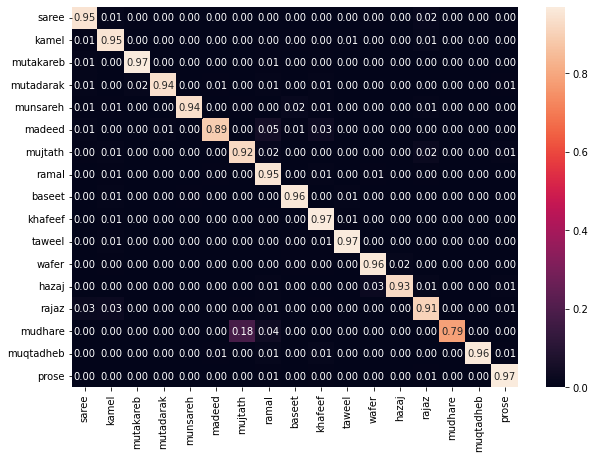

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred.argmax(-1))
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cmn, label2name, label2name)
plt.figure(figsize=(10,7))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, fmt='.2f') # font size

plt.show()

In [ ]:
accuracy_for_mudhare = 0
mudhare_baits = []
for i, lbl in enumerate(y_text_test):
  if lbl == 14:
    text = X_text_test[i]
    mudhare_baits.append(text)
    x = [[char2idx[char] for char in text]]
    x = pad_sequences(x, padding='post', value=0, maxlen = 128)
    logits = model.predict(x)[0]
    top_k_lbls = (-logits).argsort()[:5]
    # print(text)
    # for pred_lbl in top_k_lbls:
    #   print(label2name[pred_lbl])
    if top_k_lbls[0] != 14:
      print(text)
      print(top_k_lbls)
    else:
      accuracy_for_mudhare += 1


accuracy_for_mudhare / len(mudhare_baits)
        

انا المنادي بذل # وانت عني غني
[ 6 13  7  2  4]
فلم يجبني بعيد # وليس في القرب موئل
[ 6 13  9  4  8]
صلاة الورى عليه # وصلاة من هداكا
[ 7  5  9  0 16]
لكم فؤادي دواماً # وإنما الروح أنتمْ
[ 6  9 14  7 13]
بنيت في البال قصرا # وقلت من سوف ينزل
[ 6  7  4  8 13]
فكلنا سوف يبلى # وأنت وحدك حي
[ 6 12 14  7 13]


0.7857142857142857

In [ ]:
!wget 'https://raw.githubusercontent.com/zaidalyafeai/Arabic-Poetry/master/final_baits.zip'
!unzip final_baits.zip

--2022-05-19 03:29:11--  https://raw.githubusercontent.com/zaidalyafeai/Arabic-Poetry/master/final_baits.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2267882 (2.2M) [application/zip]
Saving to: ‘final_baits.zip’

final_baits.zip     100%[===================>]   2.16M  --.-KB/s    in 0.04s   

2022-05-19 03:29:12 (57.1 MB/s) - ‘final_baits.zip’ saved [2267882/2267882]

Archive:  final_baits.zip
   creating: final_baits/
  inflating: final_baits/train.txt   
  inflating: final_baits/labels.txt  
  inflating: final_baits/test.txt    


In [ ]:
metrec_x_test, metrec_y_test = extract_data('final_baits/test.txt')

metrec_x = []

for text in metrec_x_test:
  x = [[char2idx[char] for char in text]]
  x = pad_sequences(x, padding='post', value=0, maxlen = 128)
  metrec_x.append(x[0])
metrec_x, metrec_y = np.array(metrec_x), np.array(metrec_y_test)

{'(', '،', 'ـ', ':', '\u200f', '!', '؟', ')'}
8316


In [ ]:
model.evaluate(metrec_x, metrec_y, batch_size = 256)

33/33 [==============================] - 1s 39ms/step - loss: 0.1553 - accuracy: 0.9701


[0.15531587600708008, 0.9700577259063721]

In [ ]:
metrec_y_pred = model.predict(metrec_x, batch_size = 256)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


16


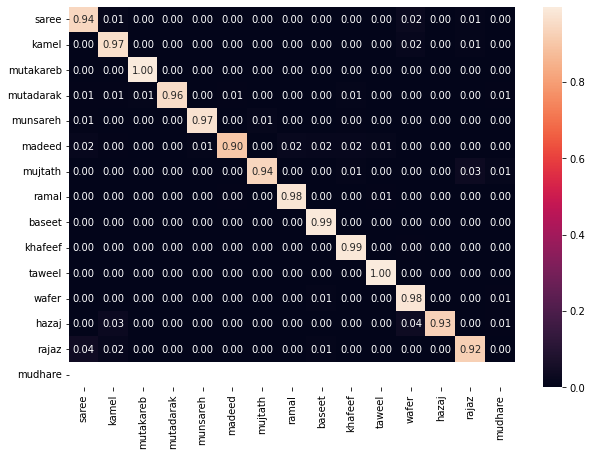

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(metrec_y_test, metrec_y_pred.argmax(-1))
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(metrec_y_pred.argmax(-1).max())
df_cm = pd.DataFrame(cmn, label2name[:cm.shape[0]], label2name[:cm.shape[0]])
plt.figure(figsize=(10,7))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, fmt='.2f') # font size

plt.show()